# Object Detection

In this notebook, we will build a simple object detection model with two heads:

- a classification head to predict the class of the object in the image
- a localization head to predict the bounding box of the object in the image

We will use the Pascal VOC 2007 dataset, which contains 20 classes of objects. We will only use 5 classes: "dog", "cat", "bus", "car", "aeroplane". To get started, we will use a pre-trained ResNet50 model to precompute the convolutional representations of the images. We will then build a simple model to predict the class and the bounding box of the object in the image.

In [4]:
import os.path as op
import tarfile
from urllib.request import urlretrieve

URL_VOC = ("https://github.com/alexwolson/pascal-voc-2007-mirror/"
           "raw/main/VOCtrainval_06-Nov-2007.tar.gz")
FILE_VOC = "VOCtrainval_06-Nov-2007.tar.gz"
FOLDER_VOC = "VOCdevkit"

if not op.exists(FILE_VOC):
    print(f'Downloading from {URL_VOC} to {FILE_VOC}...')
    urlretrieve(URL_VOC, './' + FILE_VOC)

if not op.exists(FOLDER_VOC):
    print(f'Extracting {FILE_VOC}...')
    with tarfile.open(FILE_VOC) as tar:
        tar.extractall()

print("Done!")

Extracting VOCtrainval_06-Nov-2007.tar.gz...
Done!


# Classification and Localization model

The objective is to build and train a classification and localization network. This exercise will showcase the flexibility of Deep Learning with several, heterogenous outputs (bounding boxes and classes)

We will build the model in three consecutive steps:
- **Extract label annotations** from a standard Object Detection dataset, namely **Pascal VOC 2007**;
- Use a pre-trained image classification model (namely ResNet50) to **precompute convolutional representations** with shape `(7, 7, 2048)` for all the images in the object detection training set;
- **Design and train a baseline object detection model with two heads** to predict:
  - class labels (5 possible classes)
  - bounding box coordinates of a single detected object in the image

## Loading images and annotations

We will be using Pascal VOC 2007, a dataset widely used in detection and segmentation http://host.robots.ox.ac.uk/pascal/VOC/ To lower memory footprint and training time, we'll only use 5 classes: "dog", "cat", "bus", "car", "aeroplane". Here are the first steps:
- Load the annotations file from pascalVOC and parse it (xml file)
- Keep only the annotations we're interested in, and containing a single object
- Pre-compute ResNet conv5c from the corresponding images


In [5]:
import numpy as np
import xml.etree.ElementTree as etree
import os
import os.path as op

# Parse the xml annotation file and retrieve the path to each image,
# its size and annotations
def extract_xml_annotation(filename):
    z = etree.parse(filename)
    objects = z.findall("./object")
    size = (int(z.find(".//width").text), int(z.find(".//height").text))
    fname = z.find("./filename").text
    dicts = [{obj.find("name").text:[int(obj.find("bndbox/xmin").text),
                                     int(obj.find("bndbox/ymin").text),
                                     int(obj.find("bndbox/xmax").text),
                                     int(obj.find("bndbox/ymax").text)]}
             for obj in objects]
    return {"size": size, "filename": fname, "objects": dicts}

In [6]:
# Filters annotations keeping only those we are interested in
# We only keep images in which there is a single item
annotations = []

filters = ["dog", "cat", "bus", "car", "aeroplane"]
idx2labels = {k: v for k, v in enumerate(filters)}
labels2idx = {v: k for k, v in idx2labels.items()}

annotation_folder = "VOCdevkit/VOC2007/Annotations/"
for filename in sorted(os.listdir(annotation_folder)):
    annotation = extract_xml_annotation(op.join(annotation_folder, filename))

    new_objects = []
    for obj in annotation["objects"]:
        # keep only labels we're interested in
        if list(obj.keys())[0] in filters:
            new_objects.append(obj)

    # Keep only if there's a single object in the image
    if len(new_objects) == 1:
        annotation["class"] = list(new_objects[0].keys())[0]
        annotation["bbox"] = list(new_objects[0].values())[0]
        annotation.pop("objects")
        annotations.append(annotation)

In [7]:
print("Number of images with annotations:", len(annotations))

Number of images with annotations: 2546


In [8]:
print("Contents of annotation[0]:\n", annotations[0])

Contents of annotation[0]:
 {'size': (353, 500), 'filename': '000001.jpg', 'class': 'dog', 'bbox': [48, 240, 195, 371]}


Image shape: (500, 353, 3)


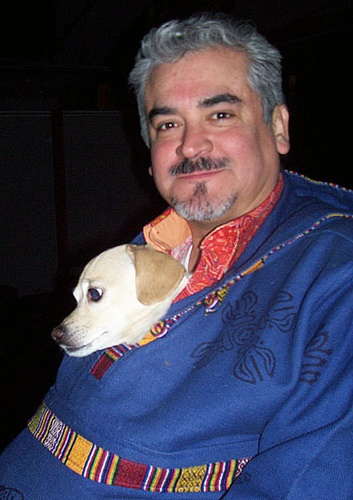

In [9]:
# Show the image corresponding to annotation[0]
from skimage.io import imread
from IPython.display import Image

img = imread("VOCdevkit/VOC2007/JPEGImages/" + annotations[0]["filename"])
print("Image shape:", img.shape)
Image("VOCdevkit/VOC2007/JPEGImages/" + annotations[0]["filename"])


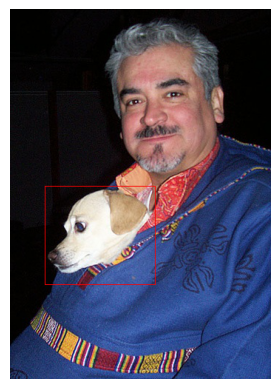

Class: dog


In [10]:
import matplotlib.pyplot as plt
from skimage.draw import rectangle_perimeter

def draw_bbox(img, bbox, color=(255, 0, 0)): 
    img = img.copy()
    rr, cc = rectangle_perimeter((bbox[1], bbox[0]), (bbox[3], bbox[2]), shape=img.shape)

    if img.ndim == 2:
        img[rr, cc] = 255
    else:  # RGB
        for i in range(3):
            img[rr, cc, i] = color[i]

    return img

# Display the image using matplotlib
plt.imshow(draw_bbox(img, annotations[0]["bbox"]))
plt.axis("off")  # Remove axis for better visualization
plt.show()

print(f'Class: {annotations[0]["class"]}')

In [11]:
print("Correspondence between indices and labels:\n", idx2labels)

Correspondence between indices and labels:
 {0: 'dog', 1: 'cat', 2: 'bus', 3: 'car', 4: 'aeroplane'}


## Pre-computing representations

Before designing the object detection model itself, we will use a pre-trained model to precompute the convolutional representations of the images. This will allow us to train the object detection model much faster. In simpler terms, what we are doing is using a pre-trained model to extract features from the images, and then we will train a simple model to predict the class and bounding box of the object in the image using these features.

In the following cell, we'll download a pre-trained ResNet model and remove the last layers of the model to keep only the convolutional part. We will then use this model to precompute the representations of the images in the dataset.

In [12]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model

model = ResNet50(include_top=False, weights='imagenet')
# Remove the average pooling layer
output = model.layers[-2].output
headless_conv = Model(inputs=model.input, outputs=model.layers[-2].output)

94765736/94765736 [==============================] - 9s 0us/step


### Predicting on a batch of images

The `predict_batch` function is defined as follows:
- open each image, and resize them to `img_size`
- stack them as a batch tensor of shape `(batch, img_size_x, img_size_y, 3)`
- preprocess the batch and make a forward pass with the model

In [13]:
from skimage.io import imread
from skimage.transform import resize

from tensorflow.keras.applications.imagenet_utils import preprocess_input

def predict_batch(model, img_batch, img_size=None):
    img_list = []

    for img in img_batch:
        if img_size:
            img = resize(img, img_size, mode='reflect', preserve_range=True)

        img = img.astype('float32')
        img_list.append(img)
    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        raise ValueError(
            'when both img_size and crop_size are None, all images '
            'in image_paths must have the same shapes.')

    return model(preprocess_input(img_batch)).numpy()

Let's test our model:

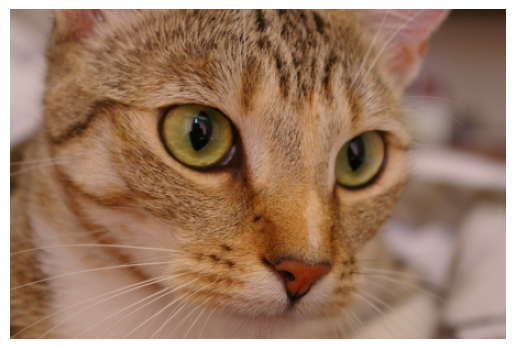

In [14]:
from  skimage import data
image = data.cat()

plt.imshow(image)
plt.axis("off")
plt.show()

In [15]:
output = predict_batch(headless_conv, [image], (1000, 224))
print("output shape", output.shape)

output shape (1, 32, 7, 2048)


The output size is `(batch_size, 1000/32 = 32, 224/32 = 7, 2048)`

### Compute representations on all images in our annotations

We will use the ResNet50 model to compute convolutional representations for all images in our filtered annotations.

Computing representations for all images may take some time (especially without a GPU), so we'll cache them to disk in `voc_representations.h5`. If the file already exists, we'll load from it; otherwise, we'll compute the representations and save them for future use.

In [16]:
import h5py
import numpy as np
from tqdm import tqdm
from skimage.io import imread

CACHE_FILE = 'voc_representations.h5'

if op.exists(CACHE_FILE):
    print(f"Loading cached representations from {CACHE_FILE}...")
    with h5py.File(CACHE_FILE, 'r') as h5f:
        reprs = h5f['reprs'][:]
    print(f"Loaded {len(reprs)} cached representations")
else:
    print(f"Computing representations for {len(annotations)} images...")
    print("This may take a few minutes...")

    batch_size = 32
    all_reprs = []

    for i in tqdm(range(0, len(annotations), batch_size)):
        batch_annotations = annotations[i:i+batch_size]
        img_paths = ["VOCdevkit/VOC2007/JPEGImages/" + ann['filename'] for ann in batch_annotations]

        batch_imgs = [imread(path) for path in img_paths]

        batch_reprs = predict_batch(headless_conv, batch_imgs, img_size=(224, 224))
        all_reprs.append(batch_reprs)

    reprs = np.vstack(all_reprs)
    print(f"Computed {len(reprs)} representations with shape {reprs.shape}")

    print(f"Saving representations to {CACHE_FILE}...")
    with h5py.File(CACHE_FILE, 'w') as h5f:
        h5f.create_dataset('reprs', data=reprs)
    print("Saved! Next time this will load instantly.")

Computing representations for 2546 images...
This may take a few minutes...


100%|██████████| 80/80 [02:10<00:00,  1.64s/it]


Computed 2546 representations with shape (2546, 7, 7, 2048)
Saving representations to voc_representations.h5...
Saved! Next time this will load instantly.


## Building ground truth from annotation

We cannot use directly the annotation dictionary as ground truth in our model. This is because the model will output a tensor of shape `(batch, num_classes)` for the classes and a tensor of shape `(batch, 4)` for the boxes coordinates. We will build the `y_true` tensor that will be compared to the output of the model.

#### Boxes coordinates

- The image is resized to a fixed 224x224 to be fed to the usual ResNet50 input, the boxes coordinates of the annotations need to be resized accordingly.
- We have to convert the top-left and bottom-right coordinates `(x1, y1, x2, y2)` to center, height, width `(xc, yc, w, h)`

#### Classes labels

- The class labels are mapped to corresponding indexes

In [17]:
img_resize = 224
num_classes = len(labels2idx.keys())


def tensorize_ground_truth(annotations):
    all_boxes = []
    all_cls = []
    for idx, annotation in enumerate(annotations):
        # Build a one-hot encoding of the class
        cls = np.zeros((num_classes))
        cls_idx = labels2idx[annotation["class"]]
        cls[cls_idx] = 1.0

        coords = annotation["bbox"]
        size = annotation["size"]
        # resize the image
        x1, y1, x2, y2 = (coords[0] * img_resize / size[0],
                          coords[1] * img_resize / size[1],
                          coords[2] * img_resize / size[0],
                          coords[3] * img_resize / size[1])

        # compute center of the box and its height and width
        cx, cy = ((x2 + x1) / 2, (y2 + y1) / 2)
        w = x2 - x1
        h = y2 - y1
        boxes = np.array([cx, cy, w, h])
        all_boxes.append(boxes)
        all_cls.append(cls)

    # stack everything into two big np tensors
    return np.vstack(all_cls), np.vstack(all_boxes)

In [18]:
classes, boxes = tensorize_ground_truth(annotations)

In [19]:
print("Classes and boxes shapes:", classes.shape, boxes.shape)

Classes and boxes shapes: (2546, 5) (2546, 4)


In [20]:
print("First 2 classes labels:\n")
print(classes[0:2])

First 2 classes labels:

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [21]:
idx2labels

{0: 'dog', 1: 'cat', 2: 'bus', 3: 'car', 4: 'aeroplane'}

In [22]:
print("First 2 boxes coordinates:\n")
print(boxes[0:2])

First 2 boxes coordinates:

[[ 77.09915014 136.864       93.28045326  58.688     ]
 [143.584      127.80780781 160.832      188.34834835]]


### Interpreting output of model

Interpreting the output of the model is going from the output tensors to a set of classes (with confidence) and boxes coordinates. It corresponds to reverting the previous process.


In [23]:
def interpret_output(cls, boxes, img_size=(500, 333)):
    cls_idx = np.argmax(cls)
    confidence = cls[cls_idx]
    classname = idx2labels[cls_idx]
    cx, cy = boxes[0], boxes[1]
    w, h = boxes[2], boxes[3]

    small_box = [max(0, cx - w / 2), max(0, cy - h / 2),
                 min(img_resize, cx + w / 2), min(img_resize, cy + h / 2)]

    fullsize_box = [int(small_box[0] * img_size[0] / img_resize),
                    int(small_box[1] * img_size[1] / img_resize),
                    int(small_box[2] * img_size[0] / img_resize),
                    int(small_box[3] * img_size[1] / img_resize)]
    output = {"class": classname, "confidence": confidence, "bbox": fullsize_box}
    return output

**Sanity check**: interpret the classes and boxes tensors of some known annotations:

In [24]:
img_idx = 1

print("Original annotation:\n")
print(annotations[img_idx])

Original annotation:

{'size': (500, 333), 'filename': '000007.jpg', 'class': 'car', 'bbox': [141, 50, 500, 330]}


In [25]:
print("Interpreted output:\n")
print(interpret_output(classes[img_idx], boxes[img_idx],
                       img_size=annotations[img_idx]["size"]))

Interpreted output:

{'class': 'car', 'confidence': 1.0, 'bbox': [141, 50, 500, 330]}


### Intersection over Union

In order to assess the quality of our model, we will monitor the IoU between ground truth box and predicted box.
The following function computes the IoU:

In [26]:
def iou(boxA, boxB):
    # find the intersecting box coordinates
    x0 = max(boxA[0], boxB[0])
    y0 = max(boxA[1], boxB[1])
    x1 = min(boxA[2], boxB[2])
    y1 = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    inter_area = max(x1 - x0, 0) * max(y1 - y0, 0)

    # compute the area of each box
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of areas - the interesection area
    return inter_area / float(boxA_area + boxB_area - inter_area)

In [27]:
iou([47, 35, 147, 101], [1, 124, 496, 235])

0.0

In [28]:
iou([47, 35, 147, 101], [47, 35, 147, 101])

1.0

In [29]:
iou([47, 35, 147, 101], [49, 36, 145, 100])

0.9309090909090909

### Classification and Localization model

A two-headed model for single object classification and localization.

In [34]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Input, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model


def classif_and_loc_bad_model(num_classes):
    """bad model that averages all the spatial information"""

    model_input = Input(shape=(7, 7, 2048))
    x = GlobalAveragePooling2D()(model_input)  # We aren't doing any convolutional operation

    # Now we build two separate heads for the model: one for classification and one for localization
    # Each takes in the output of the global average pooling layer
    class_prediction_head = Dense(num_classes, activation="softmax", name="head_classes")(x)

    box_prediction_head = Dense(4, name="head_boxes")(x)

    # Note that our model has two outputs
    model = Model(model_input, outputs=[class_prediction_head, box_prediction_head],
                  name="resnet_loc")
    model.compile(optimizer="adam", loss=[categorical_crossentropy, "mse"],
                  loss_weights=[1., 10.])
    return model

In [35]:
bad_model = classif_and_loc_bad_model(num_classes)
bad_model.summary()

Model: "resnet_loc"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 7, 7, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['input_2[0][0]']                
 alAveragePooling2D)                                                                              
                                                                                                  
 head_classes (Dense)           (None, 5)            10245       ['global_average_pooling2d[0][0]'
                                                                 ]                       

Let's debug the model: select only a few examples and test the model before training with random weights:

In [36]:
num = 64
inputs = reprs[0:num]
out_cls, out_boxes = classes[0:num], boxes[0:num]

print("Input batch shape:", inputs.shape)
print("Ground truth batch shapes:", out_cls.shape, out_boxes.shape)

Input batch shape: (64, 7, 7, 2048)
Ground truth batch shapes: (64, 5) (64, 4)


Let's check that the classes are approximately balanced (except class 2 which is 'bus'):

In [37]:
out_cls.mean(axis=0)

array([0.296875, 0.28125 , 0.0625  , 0.296875, 0.0625  ])

In [38]:
out = bad_model(inputs)
print("model output shapes:", out[0].shape, out[1].shape)

model output shapes: (64, 5) (64, 4)


Now check whether the loss decreases and eventually if we are able to overfit on these few examples for debugging purpose.

In [49]:
history = bad_model.fit(inputs, [out_cls, out_boxes],
                           batch_size=10, epochs=10)

Epoch 1/10
7/7 [==============================] - 0s 1ms/step - loss: 152406.3125 - head_classes_loss: 2.7477 - head_boxes_loss: 15240.3564
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 111609.3594 - head_classes_loss: 1.1618 - head_boxes_loss: 11160.8184
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 80931.1094 - head_classes_loss: 0.6010 - head_boxes_loss: 8093.0508
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 57127.5234 - head_classes_loss: 0.4024 - head_boxes_loss: 5712.7119
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 40666.4375 - head_classes_loss: 0.1387 - head_boxes_loss: 4066.6299
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 30512.9707 - head_classes_loss: 0.0693 - head_boxes_loss: 3051.2900
Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 24595.1133 - head_classes_loss: 0.0337 - head_boxes_loss: 2459.5081
Epoch 8/10
7/7 [==============

In [39]:
import matplotlib.pyplot as plt
plt.plot(np.log(history.history["head_boxes_loss"]), label="boxes_loss")
plt.plot(np.log(history.history["head_classes_loss"]), label="classes_loss")
plt.plot(np.log(history.history["loss"]), label="loss")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

NameError: name 'history' is not defined

### Displaying images and bounding box

In order to display our annotations, we build the function `plot_annotations` as follows:
- display the image
- display on top annotations and ground truth bounding boxes and classes

The `display` function:
- takes a single index and computes the result of the model
- interpret the output of the model as a bounding box
- calls the `plot_annotations` function

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

def patch(axis, bbox, display_txt, color):
    coords = (bbox[0], bbox[1]), bbox[2]-bbox[0]+1, bbox[3]-bbox[1]+1
    axis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    axis.text(bbox[0], bbox[1], display_txt, color='white',
              bbox={'facecolor': color, 'alpha': 0.7})


def plot_annotations(img_path, annotation=None, ground_truth=None, figsize=(10, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    img = imread(img_path)
    ax.imshow(img)
    if ground_truth:
        text = "gt " + ground_truth["class"]
        patch(ax, ground_truth["bbox"], text, "red")
    if annotation:
        conf = '{:0.2f} '.format(annotation['confidence'])
        text = conf + annotation["class"]
        patch(ax, annotation["bbox"], text, "blue")
    plt.axis('off')
    plt.show()


def display_prediction(model, index, ground_truth=True):
    res = model(reprs[index][np.newaxis,])
    output = interpret_output(res[0][0], res[1][0], img_size=annotations[index]["size"])
    plot_annotations("VOCdevkit/VOC2007/JPEGImages/" + annotations[index]["filename"],
                     output, annotations[index] if ground_truth else None)

Let's display the predictions of the model and the ground truth annotation for a couple of images in our tiny debugging training set:

In [ ]:
display_prediction(bad_model, 13)

The class should be right but the localization has little chance to be correct.

The model has even more trouble on images that were not part of our tiny debugging training set:

In [ ]:
display_prediction(bad_model, 52)

### Computing Accuracy

For each example `(class_true, bbox_true)`, we consider it positive if and only if:
- the argmax of `output_class` of the model is `class_true`
- the IoU between the `output_bbox` and the `bbox_true` is above a threshold (usually `0.5`)

The accuracy of a model is then number of positive / total_number

The following functions compute the class accuracy, iou average and global accuracy:

In [41]:
# Compute class accuracy, iou average and global accuracy
def accuracy_and_iou(preds, trues, threshold=0.5):
    sum_valid, sum_accurate, sum_iou = 0, 0, 0
    num = len(preds)
    for pred, true in zip(preds, trues):
        iou_value = iou(pred["bbox"], true["bbox"])
        if pred["class"] == true["class"] and iou_value > threshold:
            sum_valid = sum_valid + 1
        sum_iou = sum_iou + iou_value
        if pred["class"] == true["class"]:
            sum_accurate = sum_accurate + 1
    return sum_accurate / num, sum_iou / num, sum_valid / num

In [42]:
# Compute accuracy metrics for a given split (explicit API)
def compute_acc(model, reprs_split, annotations_split, split_name="eval"):
    if len(reprs_split) == 0:
        print(f"[{split_name}] Warning: Empty split, skipping evaluation")
        return

    res = model.predict(reprs_split, batch_size=32, verbose=0)
    outputs = []
    for index, (classes, boxes) in enumerate(zip(res[0], res[1])):
        output = interpret_output(classes, boxes,
                                  img_size=annotations_split[index]["size"])
        outputs.append(output)

    acc, iou, valid = accuracy_and_iou(outputs, annotations_split, threshold=0.5)
    print('[{}] class accuracy: {:0.3f}, mean IoU: {:0.3f}, valid accuracy: {:0.3f}'.format(
        split_name, acc, iou, valid))

In [43]:
# For initial evaluation before train/test split variables exist
n_samples = len(annotations)
train_split_end = (9 * n_samples) // 10
compute_acc(bad_model, reprs[:train_split_end], annotations[:train_split_end], "train")
compute_acc(bad_model, reprs[train_split_end:], annotations[train_split_end:], "test")

2025-10-29 21:03:15.036830: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[train] class accuracy: 0.322, mean IoU: 0.000, valid accuracy: 0.000
[test] class accuracy: 0.294, mean IoU: 0.000, valid accuracy: 0.000


The class accuracy is not too bad. What is the chance level for this problem? The localization measure by IoU is really bad.


### Training on the whole dataset

We split our dataset into a train and a test dataset.

Then train the model on the whole training set.

In [32]:
# Keep last examples for test
test_num = reprs.shape[0] // 10
train_num = reprs.shape[0] - test_num
test_inputs = reprs[train_num:]
test_cls, test_boxes = classes[train_num:], boxes[train_num:]
print(train_num)

2292


In [33]:
bad_model = classif_and_loc_bad_model(num_classes)

NameError: name 'classif_and_loc_bad_model' is not defined

In [ ]:
batch_size = 32
inputs = reprs[0:train_num]
out_cls, out_boxes = classes[0:train_num], boxes[0:train_num]

history = bad_model.fit(inputs, y=[out_cls, out_boxes],
                           validation_data=(test_inputs, [test_cls, test_boxes]),
                           batch_size=batch_size, epochs=10, verbose=2)

In [48]:
compute_acc(bad_model, reprs[:train_num], annotations[:train_num], "train")
compute_acc(bad_model, reprs[train_num:], annotations[train_num:], "test")

[train] class accuracy: 0.322, mean IoU: 0.000, valid accuracy: 0.000
[test] class accuracy: 0.291, mean IoU: 0.000, valid accuracy: 0.000


The class accuracy is quite good. The **localization quality measured by IoU** is slightly better that previously but still **poor even when measured on the training set**. The poor design of the localization head is causing the model to under fit.


### Build a better model

**Exercise**

Use any tool at your disposal to build a better model:
- `Dropout`
- `Convolution2D`, `Dense`, with activations functions
- `Flatten`, `GlobalAveragePooling2D`, `GlobalMaxPooling2D`, etc.

Notes:
- Be careful not to add too parametrized layers as you only have ~1200 training samples
- Feel free to modify hyperparameters: learning rate, optimizers, loss_weights

In [46]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam


In [44]:

def classif_and_loc(num_classes):

    model_input = Input(shape=(7, 7, 2048))

    # Add Conv2D layers
    x = Conv2D(256, (1, 1), activation=None, padding='same')(model_input)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(128, (3, 3), activation=None, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Dropout(0.1)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)  
    
    # We aren't doing any convolutional operation

    # Now we build two separate heads for the model: one for classification and one for localization
    # Each takes in the output of the global average pooling layer
    class_prediction_head = Dense(num_classes, activation="softmax", name="head_classes")(x)

    box_prediction_head = Dense(4, activation='linear', name="head_boxes")(x)

    # Note that our model has two outputs
    model = Model(model_input, outputs=[class_prediction_head, box_prediction_head],
                  name="resnet_loc")
    model.compile(optimizer="adam", loss=[categorical_crossentropy, "mse"],
                  loss_weights=[1., 100.])
    return model


In [ ]:
try:
    better_model = classif_and_loc(5)

    history = better_model.fit(x = inputs, y=[out_cls, out_boxes],
                               validation_data=(test_inputs, [test_cls, test_boxes]),
                               batch_size=batch_size, epochs=10, verbose=2)

    compute_acc(better_model, train=True)
    compute_acc(better_model, train=False)

except ValueError as e:
    print(str(e) + " Possible issue: Complete the relevant section of the assignment to initialize it.")



In [ ]:
try:
    display_prediction(better_model, 11)
except ValueError as e:
    print(str(e) + " Possible issue: Complete the relevant section of the assignment to initialize it.")

In [ ]:
display_prediction(bad_model, 11)

In [ ]:
try:
    display_prediction(better_model, 52)
except ValueError as e:
    print(str(e) + " Possible issue: Complete the relevant section of the assignment to initialize it.")

In [ ]:
display_prediction(bad_model, 52)